In [1]:
import os
import glob
import pandas as pd
import numpy as np

WORK_SPACE = "/home/olle/PycharmProjects/LODE/workspace"

longitudinal_pd = pd.read_csv(os.path.join(WORK_SPACE, "longitudinal_data.csv"))
segmentation_statistics_pd = pd.read_csv(os.path.join(WORK_SPACE, "segmentation_statistics.csv"))

#### pre process columns

In [2]:
id_cols = segmentation_statistics_pd.record.str.split("_", expand=True)[[0, 1 , 2, 3]]

segmentation_statistics_pd["patient_id"] = id_cols[0]
segmentation_statistics_pd["study_date"] = id_cols[1]
segmentation_statistics_pd["laterality"] = id_cols[2]

longitudinal_pd["study_date"] = longitudinal_pd.study_date.str.replace("-", "")

In [3]:
# cast data types
keys = ["patient_id", "study_date", "laterality"] 
for key in keys:
    longitudinal_pd[key] = longitudinal_pd[key].astype(str)
    segmentation_statistics_pd[key] = segmentation_statistics_pd[key].astype(str)

#### merge

In [5]:
longitudinal_abt = pd.merge(longitudinal_pd, segmentation_statistics_pd, how="inner", 
                            left_on = keys, right_on = keys)

feature_columns = list(longitudinal_abt.columns[17:])

#### correlation table

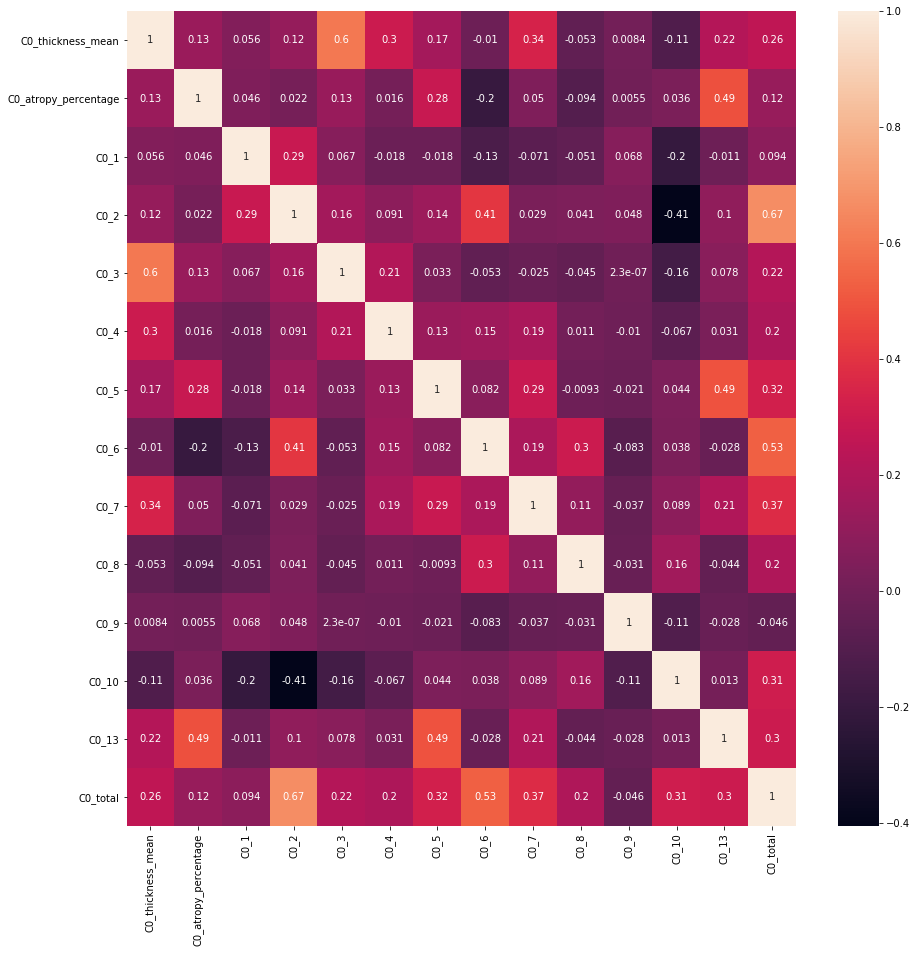

In [6]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

fovea_feature_columns = [feature for feature in feature_columns if "C0" in feature]
corrMatrix = longitudinal_abt[fovea_feature_columns].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#### split data with patient stratification

In [6]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
X = longitudinal_abt[feature_columns]
y = longitudinal_abt.logMAR
groups = longitudinal_abt.patient_id

gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)

train_idx, eval_idx = next(gss.split(X, y, groups))

train_x = X.iloc[train_idx]
train_y = y.iloc[train_idx]

test_x = X.iloc[eval_idx]
test_y = y.iloc[eval_idx]

train_x.shape, test_x.shape

((18549, 126), (4411, 126))

In [7]:
def evaluate_regressor(regr):
        # Train the model using the training sets
    regr.fit(train_x, train_y)

    # Make predictions using the testing set
    y_pred = regr.predict(test_x)

    # The coefficients
    # print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print('Mean absolute error: %.2f'
          % mean_absolute_error(test_y, y_pred))

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

# Create linear regression object
lasso_regr = linear_model.Lasso(alpha=0.1)
random_forest_regr = RandomForestRegressor(n_estimators = 100, max_depth=10, criterion='mse')
linear_regr = linear_model.LinearRegression()
ridge_regr = Ridge(alpha=1.0)
bagging_regr = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=0)

regressors = [bagging_regr]
for regr in regressors:
    print(str(regr.__class__))
    evaluate_regressor(regr)

<class 'sklearn.ensemble.bagging.BaggingRegressor'>


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/olle/miniconda3/

Mean absolute error: 0.35
